# DATA CLEANING

In [3]:
import pandas as pd
import numpy as np
import re

file_path = "C:\\Users\\TARU\\OneDrive\\Desktop\\AMITY\\DATA _LG\\1006\\Noisy.xlsx"
df = pd.read_excel(file_path, sheet_name='Train')

print("\n🔍 Initial Overview:")
print(df.info())
print(df.describe(include='all'))

duplicates = df.duplicated()
print(f"\n🔁 Number of duplicate rows: {duplicates.sum()}")
df = df.drop_duplicates()

print("\n🚫 Null Value Report:")
print(df.isnull().sum())

df = df.dropna()
print("\n✅ Data cleaning complete.")


🔍 Initial Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161789 entries, 0 to 161788
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   data    161789 non-null  object
 1   label   161789 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB
None
                                         data          label
count                                  161789  161789.000000
unique                                 161723            NaN
top     Chennai, Tamil Nadu, near Main Market            NaN
freq                                        4            NaN
mean                                      NaN       1.000185
std                                       NaN       0.816509
min                                       NaN       0.000000
25%                                       NaN       0.000000
50%                                       NaN       1.000000
75%                                       NaN       2.00

# FEATURE ENGINEERING

In [9]:
import pandas as pd
import re
import string
from sklearn.cluster import KMeans

file_path = "C:\\Users\\TARU\\OneDrive\\Desktop\\AMITY\\DATA _LG\\1006\\Noisy.xlsx"
df = pd.read_excel(file_path, sheet_name='Train')
data_col = 'data'

def clean_text(text):
    try:
        return str(text).encode('latin1').decode('utf-8')
    except:
        return str(text)

def word_count(text):
    return len(text.split())

def space_count(text):
    return text.count(" ")

def char_counts(text):
    digits = sum(c.isdigit() for c in text)
    alphabets = sum(c.isalpha() for c in text)
    specials = sum(not c.isalnum() and not c.isspace() for c in text)
    vowels = sum(c.lower() in "aeiou" for c in text)
    consonants = alphabets - vowels
    return digits, alphabets, specials, vowels, consonants

def count_symbol(text, symbol):
    return text.count(symbol)

def has_consecutive_specials(text):
    return int(bool(re.search(r'[^a-zA-Z0-9\s]{2,}', text)))

def has_email_pattern(text):
    return int(bool(re.match(r"^[\w\.-]+@[\w\.-]+\.\w+$", text.strip())))

def has_pincode_pattern(text):
    return int(bool(re.search(r'\b\d{6}\b', text)))

def has_valid_tld(text):
    valid_tlds = [
        "com", "org", "net", "edu", "gov", "co",  # Global
        "in", "co.in", "org.in", "gov.in", "nic.in", "ac.in",  # Indian
        "edu.in", "res.in", "ernet.in", "mil.in", "net.in",
        "firm.in", "gen.in", "ind.in"
    ]
    pattern = r'\.(' + '|'.join(re.escape(tld) for tld in valid_tlds) + r')(\W|$)'
    return int(bool(re.search(pattern, text)))

def has_keyword(text, keyword_list):
    text_lower = text.lower()
    return int(any(kw.lower() in text_lower for kw in keyword_list))

def char_type(c):
    if c.isalpha():
        return "letter"
    elif c.isdigit():
        return "digit"
    else:
        return "special"

state_keywords = ["Andhra Pradesh", "AP", "Arunachal Pradesh", "Arunachal", "AR", "Assam", "AS",
"Bihar", "BR", "Chhattisgarh", "Chh.", "CG", "Goa", "GA", "Gujarat", "GJ", "Haryana", "HR",
"Himachal Pradesh", "Himachal", "HP", "Jharkhand", "JH", "Karnataka", "KA", "Kerala", "KL",
"Madhya Pradesh", "MP", "M.P.", "Maharashtra", "MH", "Maha.", "Manipur", "MN", "Meghalaya", "ML",
"Mizoram", "MZ", "Nagaland", "NL", "Odisha", "OR", "Od.", "Punjab", "PB", "Rajasthan", "RJ",
"Sikkim", "SK", "Tamil Nadu", "TN", "Telangana", "TS", "TG", "Tripura", "TR", "Uttar Pradesh",
"UP", "U.P.", "Uttarakhand", "UK", "Utt.", "West Bengal", "WB", "W.B.", "Andaman and Nicobar Islands",
"ANI", "A&N", "Chandigarh", "CH", "Dadra and Nagar Haveli and Daman and Diu", "DNHDD", "Delhi",
"DL", "NCT", "Delhi NCR", "Jammu and Kashmir", "J&K", "Ladakh", "LA", "Lakshadweep", "LD",
"Puducherry", "PY", "Pondy"]

city_keywords = ["Bamboo Flat", "Nicobar", "Port Blair", "South Andaman", "Addanki", "Adoni", "Akasahebpet", "Akividu", "Akkarampalle", "Amalapuram", "Amudalavalasa", "Anakapalle", "Anantapur", "Atmakur", "Attili", "Avanigadda", "Badvel", "Banganapalle", "Bapatla", "Betamcherla", "Bhattiprolu", "Bhimavaram", "Bhimunipatnam", "Bobbili", "Challapalle", "Chemmumiahpet", "Chilakalurupet", "Chinnachowk", "Chipurupalle", "Chirala", "Chittoor", "Chodavaram", "Cuddapah", "Cumbum", "Darsi", "Dharmavaram", "Dhone", "Diguvametta", "East Godavari", "Elamanchili", "Ellore", "Emmiganur", "Erraguntla", "Etikoppaka", "Gajuwaka", "Ganguvada", "Gannavaram", "Giddalur", "Gokavaram", "Gorantla", "Govindapuram,Chilakaluripet,Guntur", "Gudivada", "Gudlavalleru", "Gudur", "Guntakal Junction", "Guntur", "Hindupur", "Ichchapuram", "Jaggayyapeta", "Jammalamadugu", "Kadiri", "Kaikalur", "Kakinada", "Kalyandurg", "Kamalapuram", "Kandukur", "Kanigiri", "Kankipadu", "Kanuru", "Kavali", "Kolanukonda", "Kondapalle", "Korukollu", "Kosigi", "Kovvur", "Krishna", "Kuppam", "Kurnool", "Macherla", "Machilipatnam", "Madanapalle", "Madugula", "Mandapeta", "Mandasa", "Mangalagiri", "Markapur", "Nagari", "Nagireddipalli", "Nandigama", "Nandikotkur", "Nandyal", "Narasannapeta", "Narasapur", "Narasaraopet", "Narasingapuram", "Narayanavanam", "Narsipatnam", "Nayudupet", "Nellore", "Nidadavole", "Nuzvid", "Ongole", "Pakala", "Palakollu", "Palasa", "Palkonda", "Pallevada", "Palmaner", "Parlakimidi", "Parvatipuram", "Pavuluru", "Pedana", "pedda nakkalapalem", "Peddapuram", "Penugonda", "Penukonda", "Phirangipuram", "Pippara", "Pithapuram", "Polavaram", "Ponnur", "Ponnuru", "Prakasam", "Proddatur", "Pulivendla", "Punganuru", "Puttaparthi", "Puttur", "Rajahmundry", "Ramachandrapuram", "Ramanayyapeta", "Ramapuram", "Rampachodavaram", "Rayachoti", "Rayadrug", "Razam", "Razampeta", "Razole", "Renigunta", "Repalle", "Salur", "Samalkot", "Sattenapalle", "Singarayakonda", "Sompeta", "Srikakulam", "Srisailain", "Suluru", "Tadepalle", "Tadepallegudem", "Tadpatri", "Tanuku", "Tekkali", "Tirumala", "Tirupati", "Tuni", "Uravakonda", "vadlamuru", "Vadlapudi", "Venkatagiri", "Vepagunta", "Vetapalem", "Vijayawada", "Vinukonda", "Visakhapatnam", "Vizianagaram", "Vizianagaram District", "Vuyyuru", "West Godavari", "Yanam", "Yanamalakuduru", "Yarada", "Along", "Anjaw", "Basar", "Bomdila", "Changlang", "Dibang Valley", "East Kameng", "East Siang", "Hayuliang", "Itanagar", "Khonsa", "Kurung Kumey", "Lohit District", "Lower Dibang Valley", "Lower Subansiri", "Margherita", "Naharlagun", "Pasighat", "Tawang", "Tezu", "Tirap", "Upper Siang", "Upper Subansiri", "West Kameng", "West Siang", "Ziro", "Abhayapuri", "Amguri", "Badarpur", "Baksa", "Barpathar", "Barpeta", "Barpeta Road", "Basugaon", "Bihpuriagaon", "Bijni", "Bilasipara", "Bokajan", "Bokakhat", "Bongaigaon", "Cachar", "Chabua", "Chapar", "Chirang", "Darrang", "Dergaon", "Dhekiajuli", "Dhemaji", "Dhing", "Dhubri", "Dibrugarh", "Digboi", "Dima Hasao District", "Diphu", "Dispur", "Duliagaon", "Dum Duma", "Gauripur", "Goalpara", "Gohpur", "Golaghat", "Golakganj", "Goshaingaon", "Guwahati", "Haflong", "Hailakandi", "Hajo", "Hojai", "Howli", "Jogighopa", "Jorhat", "Kamrup", "Kamrup Metropolitan", "Karbi Anglong", "Karimganj", "Kharupatia", "Kokrajhar", "Lakhimpur", "Lakhipur", "Lala", "Lumding Railway Colony", "Mahur", "Maibong", "Makum", "Mangaldai", "Mariani", "Moranha", "Morigaon", "Nagaon", "Nahorkatiya", "Nalbari", "Namrup", "Nazira", "North Guwahati", "North Lakhimpur", "Numaligarh", "Palasbari", "Raha", "Rangapara", "Rangia", "Sapatgram", "Sarupathar", "Sibsagar", "Silapathar", "Silchar", "Soalkuchi", "Sonari", "Sonitpur", "Sorbhog", "Tezpur", "Tinsukia", "Titabar", "Udalguri", "Amarpur", "Araria", "Arrah", "Arwal", "Asarganj", "Aurangabad", "Bagaha", "Bahadurganj", "Bairagnia", "Baisi", "Bakhtiyarpur", "Bangaon", "Banka", "Banmankhi", "Bar Bigha", "Barauli", "Barh", "Barhiya", "Bariarpur", "Baruni", "Begusarai", "Belsand", "Bettiah", "Bhabhua", "Bhagalpur", "Bhagirathpur", "Bhawanipur", "Bhojpur", "Bihar Sharif", "Bihariganj", "Bikramganj", "Birpur", "Buddh Gaya", "Buxar", "Chakia", "Chapra", "Chhatapur", "Colgong", "Dalsingh Sarai", "Darbhanga", "Daudnagar", "Dehri", "Dhaka", "Dighwara", "Dinapore", "Dumra", "Dumraon", "Fatwa", "Forbesganj", "Gaya", "Ghoga", "Gopalganj", "Hajipur", "Hilsa", "Hisua", "Islampur", "Jagdispur", "Jahanabad", "Jamalpur", "Jamui", "Jaynagar", "Jehanabad", "Jha-Jha", "Jhanjharpur", "Jogbani", "Kaimur District", "Kasba", "Katihar", "Khagaria", "Khagaul", "Kharagpur", "Khusropur", "Kishanganj", "Koath", "Koelwar", "Lakhisarai", "Lalganj", "Luckeesarai", "Madhepura", "Madhipura", "Madhubani", "Maharajgani", "Mairwa", "Maner", "Manihari", "Marhaura", "Masaurhi Buzurg", "Mohiuddinnagar", "Mokameh", "Monghyr", "Mothihari", "Munger", "Murliganj", "Muzaffarpur", "Nabinagar", "Nalanda", "Nasriganj", "Naugachhia", "Nawada", "Nirmali", "Pashchim Champaran", "Patna", "Piro", "Pupri", "Purba Champaran", "Purnia", "Rafiganj", "Raghunathpur", "Rajgir", "Ramnagar", "Raxaul", "Revelganj", "Rohtas", "Rusera", "Sagauli", "Saharsa", "Samastipur", "Saran", "Shahbazpur", "Shahpur", "Sheikhpura", "Sheohar", "Sherghati", "Silao", "Sitamarhi", "Siwan", "Supaul", "Teghra", "Tekari", "Thakurganj", "Vaishali", "Waris Aliganj", "Akaltara", "Ambagarh Chauki", "Ambikapur", "Arang", "Baikunthpur", "Balod", "Baloda", "Baloda Bazar", "Basna", "Bastar", "Bemetara", "Bhanpuri", "Bhatapara", "Bhatgaon", "Bhilai", "Bijapur", "Bilaspur", "Champa", "Chhuikhadan", "Deori", "Dhamtari", "Dongargaon", "Dongargarh", "Durg", "Gandai", "Gariaband", "Gaurela", "Gharghoda", "Gidam", "Jagdalpur", "Janjgir", "Janjgir-Champa", "Jashpur", "Jashpurnagar", "Junagarh", "Kabeerdham", "Kanker", "Katghora", "Kawardha", "Khairagarh", "Khamharia", "Kharod", "Kharsia", "Kirandul", "Kondagaon", "Korba", "Koriya", "Kota", "Kotaparh", "Kumhari", "Kurud", "Lormi", "Mahasamund", "Mungeli", "Narayanpur", "Narharpur", "Pandaria", "Pandatarai", "Pasan", "Patan", "Pathalgaon", "Pendra", "Pithora", "Raigarh", "Raipur", "Raj Nandgaon", "Raj-Nandgaon", "Ramanuj Ganj", "Ratanpur", "Sakti", "Saraipali", "Sarangarh", "Seorinarayan", "Simga", "Surguja", "Takhatpur", "Umarkot", "Uttar Bastar Kanker", "Alipur", "Bawana", "Central Delhi", "Deoli", "East Delhi", "Karol Bagh", "Najafgarh", "Nangloi Jat", "Narela", "New Delhi", "North Delhi", "North East Delhi", "North West Delhi", "Pitampura", "Rohini", "South Delhi", "South West Delhi", "West Delhi", "Aldona", "Arambol", "Baga", "Bambolim", "Bandora", "Benaulim", "Calangute", "Candolim", "Carapur", "Cavelossim", "Chicalim", "Chinchinim", "Colovale", "Colva", "Cortalim", "Cuncolim", "Curchorem", "Curti", "Davorlim", "Dicholi", "Goa Velha", "Guirim", "Jua", "Kankon", "Madgaon", "Mapuca", "Morjim", "Mormugao", "Navelim", "North Goa", "Palle", "Panaji", "Pernem", "Ponda", "Quepem", "Queula", "Raia", "Saligao", "Sancoale", "Sanguem", "Sanquelim", "Sanvordem", "Serula", "Solim", "South Goa", "Taleigao", "Vagator", "Valpoy", "Varca", "Vasco da Gama", "Abrama", "Adalaj", "Agol", "Ahmedabad", "Ahwa", "Akrund", "Amod", "Amod,", "Amreli", "Amroli", "Anand", "Anjar", "Ankleshwar", "Babra", "Bagasara", "Bagasra", "Bakharla", "Balagam", "Balasinor", "Balisana", "Bamanbore", "Banas Kantha", "Bandia", "Bantva", "Bardoli", "Bedi", "Bhachau", "Bhadran", "Bhandu", "Bhanvad", "Bharuch", "Bhatha", "Bhavnagar", "Bhayavadar", "Bhildi", "Bhojpur Dharampur", "Bhuj", "Bilimora", "Bilkha", "Borsad", "Botad", "Chaklasi", "Chalala", "Chaloda", "Champaner", "Chanasma", "Chhala", "Chhota Udepur", "Chikhli", "Chotila", "Chuda", "Dabhoda", "Dabhoi", "Dahegam", "Dahod", "Dakor", "Damnagar", "Dandi", "Dangs (India)", "Danta", "Dayapar", "Delvada", "Delwada", "Detroj", "Devbhumi Dwarka", "Devgadh Bariya", "Dhandhuka", "Dhanera", "Dhansura", "Dharampur", "Dharasana", "Dhari", "Dhasa", "Dhola", "Dholera", "Dholka", "Dhoraji", "Dhrangadhra", "Dhrol", "Dhuwaran", "Disa", "Dohad", "Dumkhal", "Dungarpur", "Dwarka", "Gadhada", "Gandevi", "Gandhidham", "Gandhinagar", "Gariadhar", "Ghodasar", "Ghogha", "Gir Somnath", "Godhra", "Gondal", "Gorwa", "Halenda", "Halol", "Halvad", "Hansot", "Harij", "Harsol", "Hathuran", "Himatnagar", "Idar", "Jakhau", "Jalalpore", "Jalalpur", "Jalia", "Jambuda", "Jambusar", "Jamnagar", "Jarod,", "Jasdan", "Jetalpur", "Jetalsar", "Jetpur", "Jetpur (Navagadh)", "Jhalod", "Jhulasan", "Jodhpur", "Jodhpur (Ahmedabad)", "Jodia", "Jodiya Bandar", "Junagadh", "Kachchh", "Kachholi", "Kadi", "Kadod", "Kalavad", "Kalol", "Kandla", "Kandla port", "Kanodar", "Kapadvanj", "Karamsad", "Kariana", "Karjan", "Kathor", "Katpur", "Kavant", "Kawant", "Kayavarohan", "Kerwada", "Keshod", "Khambhalia", "Khambhat", "Khavda", "Kheda", "Khedbrahma", "Khedoi", "Kherali", "Kheralu", "Kodinar", "Kosamba", "Kothara", "Kotharia", "Kukarmunda", "Kukma", "Kundla", "Kutch district", "Kutiyana", "Ladol", "Lakhpat", "Lakhtar", "Lalpur", "Langhnaj", "Lathi", "Limbdi", "Limkheda", "Lunavada", "Madhavpur Ghed", "Madhi", "Mahemdavad", "Mahesana", "Mahisa", "Mahudha", "Mahuva", "Mahuva (Surat)", "Malpur", "Manavadar", "Mandal", "Mandvi", "Mandvi (Surat)", "Mangrol", "Mangrol (Junagadh)", "Mansa", "Meghraj", "Mehsana", "Mendarda", "Mithapur", "Modasa", "Morbi", "Morva (Hadaf)", "Morwa", "Mundra", "Nadiad", "Nadiad,", "Nagwa", "Naldhara", "Naliya", "Nargol", "Narmada", "Naroda", "Navsari", "Nikora", "Nizar", "Odadar", "Okha", "Olpad", "Paddhari", "Padra", "Palanpur", "Palanswa", "Palitana", "Paliyad", "Paliyad (Bhavnagar)", "Palsana", "Panch Mahals", "Panchmahal district", "Pardi", "Parnera", "Pavi Jetpur", "Petlad", "Pipavav", "Piplod", "Porbandar", "Prabhas Patan", "Prantij", "Radhanpur", "Rajkot", "Rajpipla", "Rajula", "Ranavav", "Ranpur", "Rapar", "Reha", "Roha", "Sabar Kantha", "Sachin", "Salaya", "Samakhiali", "Sanand", "Sankheda", "Sarbhon", "Sardoi", "Sarkhej", "Sathamba", "Savarkundla", "Savli", "Sayla", "Shivrajpur", "Siddhpur", "Sihor", "Sikka", "Sinor", "Sojitra", "Songadh", "Supedi", "Surat", "Surendranagar", "Sutrapada", "Talaja", "Tankara", "Tapi", "Than", "Thangadh", "Tharad", "Thasra", "The Dangs", "Umarpada", "Umrala", "Umreth", "Un", "Una", "Unjha", "Upleta", "Utran", "Vadgam", "Vadnagar", "Vadodara", "Vaghodia", "Vaghodia INA", "Vallabh Vidyanagar", "Vallabhipur", "Valsad", "Vanala", "Vansda", "Vanthli", "Vapi", "Vartej", "Vasa", "Vasavad", "Vaso", "Vataman", "Vejalpur", "Veraval", "Vijapur", "Vinchhiya", "Vinchia", "Viramgam", "Virpur", "Visavadar", "Visnagar", "Vyara", "Wadhai", "Wadhwan", "Waghai", "Wankaner", "Ambala", "Asandh", "Ateli Mandi", "Bahadurgarh", "Bara Uchana", "Barwala", "Bawal", "Beri Khas", "Bhiwani", "Buriya", "Charkhi Dadri", "Chhachhrauli", "Dabwali", "Dharuhera", "Ellenabad", "Faridabad", "Faridabad District", "Farrukhnagar", "Fatehabad", "Fatehabad District", "Firozpur Jhirka", "Gharaunda", "Gohana", "Gorakhpur", "Gurgaon", "Hansi", "Hasanpur", "Hisar", "Hodal", "Inda Chhoi", "Indri", "Jagadhri", "Jakhal", "Jhajjar", "Jind", "Kaithal", "Kalanaur", "Kalanwali", "Kanina Khas", "Karnal", "Kharkhauda", "Kheri Sampla", "Kurukshetra", "Ladwa", "Loharu", "Maham", "Mahendragarh", "Mandholi Kalan", "Mustafabad", "Narayangarh", "Narnaul", "Narnaund", "Narwana", "Nilokheri", "Nuh", "Palwal", "Panchkula", "Panipat", "Pataudi", "Pehowa", "Pinjaur", "Punahana", "Pundri", "Radaur", "Rania", "Ratia", "Rewari", "Rewari District", "Rohtak", "Safidon", "Samalkha", "Shadipur Julana", "Shahabad", "Sirsa", "Sohna", "Sonipat", "Taoru", "Thanesar", "Tohana", "Tosham", "Uklana", "Yamunanagar", "Arki", "Baddi", "Banjar", "Chamba", "Chaupal", "Chowari", "Chuari Khas", "Dagshai", "Dalhousie", "Daulatpur", "Dera Gopipur", "Dharamsala", "Gagret", "Ghumarwin", "Hamirpur", "Jawala Mukhi", "Jogindarnagar", "Jubbal", "Jutogh", "Kalka", "Kangar", "Kangra", "Kasauli", "Kinnaur", "Kotkhai", "Kotla", "Kulu", "Kyelang", "Lahul and Spiti", "Manali", "Mandi", "Nadaun", "Nagar", "Nagrota", "Nahan", "Nalagarh", "Palampur", "Pandoh", "Paonta Sahib", "Parwanoo", "Rajgarh", "Rampur", "Rohru", "Sabathu", "Santokhgarh", "Sarahan", "Sarka Ghat", "Seoni", "Shimla", "Sirmaur", "Solan", "Sundarnagar", "Theog", "Tira Sujanpur", "Yol", "Akhnur", "Anantnag", "Awantipur", "Badgam", "Bandipore", "Bandipura", "Banihal", "Baramula", "Batoti", "Bhadarwah", "Bijbehara", "Bishnah", "Doda", "Gandarbal", "Ganderbal", "Gho Brahmanan de", "Hajan", "Hiranagar", "Jammu", "Jaurian", "Kathua", "Katra", "Khaur", "Kishtwar", "Kud", "Kulgam", "Kupwara", "Ladakh", "Magam", "Nawanshahr", "Noria", "Padam", "Pahlgam", "Parol", "Pattan", "Pulwama", "Punch", "Qazigund", "Rajaori", "Rajauri", "Ramban", "Ramgarh", "Riasi", "Samba", "Shupiyan", "Sopur", "Soyibug", "Srinagar", "Sumbal", "Thang", "Thanna Mandi", "Tral", "Tsrar Sharif", "Udhampur", "Uri", "Bagra", "Barka Kana", "Barki Saria", "Barwadih", "Bhojudih", "Bokaro", "Bundu", "Chaibasa", "Chakradharpur", "Chakulia", "Chandil", "Chas", "Chatra", "Chiria", "Daltonganj", "Deogarh", "Dhanbad", "Dhanwar", "Dugda", "Dumka", "Garhwa", "Ghatsila", "Giridih", "Gobindpur", "Godda", "Gomoh", "Gopinathpur", "Gua", "Gumia", "Gumla", "Hazaribag", "Hazaribagh", "Hesla", "Husainabad", "Jagannathpur", "Jamadoba", "Jamshedpur", "Jamtara", "Jasidih", "Jharia", "Jugsalai", "Jumri Tilaiya", "Kalikapur", "Kandra", "Kanke", "Katras", "Kenduadih", "Kharsawan", "Khunti", "Kodarma", "Kuju", "Latehar", "Lohardaga", "Madhupur", "Malkera", "Manoharpur", "Mugma", "Mushabani", "Neturhat", "Nirsa", "Noamundi", "Pakur", "Palamu", "Pashchim Singhbhum", "patamda", "Pathardih", "Purba Singhbhum", "Ranchi", "Ray", "Sahibganj", "Saraikela", "Sarubera", "Sijua", "Simdega", "Sini", "Topchanchi", "Afzalpur", "Ajjampur", "Aland", "Alnavar", "Alur", "Anekal", "Ankola", "Annigeri", "Arkalgud", "Arsikere", "Athni", "Aurad", "Badami", "Bagalkot", "Bagepalli", "Bail-Hongal", "Ballari", "Ballary", "Banavar", "Bangalore Rural", "Bangalore Urban", "Bangarapet", "Bannur", "Bantval", "Basavakalyan", "Basavana Bagevadi", "Belagavi", "Belluru", "Beltangadi", "Belur", "Bengaluru", "Bhadravati", "Bhalki", "Bhatkal", "Bidar", "Bilgi", "Birur", "Byadgi", "Byndoor", "Canacona", "Challakere", "Chamrajnagar", "Channagiri", "Channapatna", "Channarayapatna", "Chik Ballapur", "Chikkaballapur", "Chikkamagaluru", "Chiknayakanhalli", "Chikodi", "Chincholi", "Chintamani", "Chitapur", "Chitradurga", "Closepet", "Coondapoor", "Dakshina Kannada", "Dandeli", "Davanagere", "Devanhalli", "Dharwad", "Dod Ballapur", "French Rocks", "Gadag", "Gadag-Betageri", "Gajendragarh", "Gangawati", "Gangolli", "Gokak", "Gokarna", "Goribidnur", "Gorur", "Gubbi", "Gudibanda", "Guledagudda", "Gundlupēt", "Gurmatkal", "Hadagalli", "Haliyal", "Hampi", "Hangal", "Harihar", "Harpanahalli", "Hassan", "Haveri", "Heggadadevankote", "Hirekerur", "Hiriyur", "Holalkere", "Hole Narsipur", "Homnabad", "Honavar", "Honnali", "Hosanagara", "Hosangadi", "Hosdurga", "Hoskote", "Hospet", "Hubballi", "Hukeri", "Hungund", "Hunsur", "Ilkal", "Indi", "Jagalur", "Jamkhandi", "Jevargi", "Kadur", "Kalaburgi", "Kalghatgi", "Kampli", "Kankanhalli", "Karkala", "Karwar", "Kavalur", "Kerur", "Khanapur", "Kodagu", "Kodigenahalli", "Kodlipet", "Kolar", "Kollegal", "Konanur", "Konnur", "Koppa", "Koppal", "Koratagere", "Kotturu", "Krishnarajpet", "Kudachi", "Kudligi", "Kumsi", "Kumta", "Kundgol", "Kunigal", "Kurgunta", "Kushalnagar", "Kushtagi", "Lakshmeshwar", "Lingsugur", "Londa", "Maddagiri", "Maddur", "Madikeri", "Magadi", "Mahalingpur", "Malavalli", "Malpe", "Malur", "Mandya", "Mangaluru", "Manipal", "Manvi", "Mayakonda", "Melukote", "Mudbidri", "Muddebihal", "Mudgal", "Mudgere", "Mudhol", "Mulbagal", "Mulgund", "Mulki", "Mundargi", "Mundgod", "Munirabad", "Murudeshwara", "Mysuru", "Nagamangala", "Nanjangud", "Narasimharajapura", "Naregal", "Nargund", "Navalgund", "Nelamangala", "Nyamti", "Pangala", "Pavugada", "Piriyapatna", "Ponnampet", "Rabkavi", "Raichur", "Ramanagara", "Ranibennur", "Raybag", "Robertsonpet", "Ron", "Sadalgi", "Sagar", "Sakleshpur", "Sandur", "Sanivarsante", "Sankeshwar", "Sargur", "Saundatti", "Savanur", "Seram", "Shiggaon", "Shikarpur", "Shimoga", "Shirhatti", "Shorapur", "Shrirangapattana", "Siddapur", "Sidlaghatta", "Sindgi", "Sindhnur", "Sira", "Sirsi", "Siruguppa", "Someshwar", "Somvarpet", "Sorab", "Sravana Belgola", "Sringeri", "Srinivaspur", "Sulya", "Suntikoppa", "Talikota", "Tarikere", "Tekkalakote", "Terdal", "Tiptur", "Tirthahalli", "Tirumakudal Narsipur", "Tumakuru", "Turuvekere", "Udupi", "Ullal", "Uttar Kannada", "Vadigenhalli", "Vijayapura", "Virarajendrapet", "Wadi", "Yadgir", "Yelahanka", "Yelandur", "Yelbarga", "Yellapur", "Adur", "Alappuzha", "Aluva", "Alwaye", "Angamali", "Aroor", "Arukutti", "Attingal", "Avanoor", "Azhikkal", "Badagara", "Beypore", "Changanacheri", "Chēlakara", "Chengannur", "Cherpulassery", "Cherthala", "Chetwayi", "Chittur", "Cochin", "Dharmadam", "Edakkulam", "Elur", "Erattupetta", "Ernakulam", "Ferokh", "Guruvayur", "Idukki", "Iringal", "Irinjalakuda", "Kadakkavoor", "Kalamassery", "Kalavoor", "Kalpatta", "Kannangad", "Kannavam", "Kannur", "Kasaragod", "Kasaragod District", "Kattanam", "Kayankulam", "Kizhake Chalakudi", "Kodungallur", "Kollam", "Kotamangalam", "Kottayam", "Kovalam", "Kozhikode", "Kumbalam", "Kunnamangalam", "Kunnamkulam", "Kunnumma", "Kutiatodu", "Kuttampuzha", "Lalam", "Mahē", "Malappuram", "Manjeri", "Manjēshvar", "Mannarakkat", "Marayur", "Mattanur", "Mavelikara", "Mavoor", "Muluppilagadu", "Munnar", "Muvattupula", "Muvattupuzha", "Nadapuram", "Naduvannur", "Nedumangad", "Neyyattinkara", "Nilēshwar", "Ottappalam", "Palackattumala", "Palakkad district", "Palghat", "Panamaram", "Pappinisshēri", "Paravur Tekkumbhagam", "Pariyapuram", "Pathanamthitta", "Pattanamtitta", "Payyannur", "Perumbavoor", "Perumpavur", "Perya", "Piravam", "Ponmana", "Ponnani", "Punalur", "Ramamangalam", "Shertallai", "Shōranur", "Talipparamba", "Tellicherry", "Thanniyam", "Thiruvananthapuram", "Thrissur", "Thrissur District", "Tirur", "Tiruvalla", "Vaikam", "Varkala", "Vayalar", "Vettur", "Wayanad", "Kargil", "Leh", "Kavaratti", "Agar", "Ajaigarh", "Akodia", "Alampur", "Alirajpur", "Alot", "Amanganj", "Amarkantak", "Amarpatan", "Amarwara", "Ambah", "Amla", "Anjad", "Antri", "Anuppur", "Aron", "Ashoknagar", "Ashta", "Babai", "Badarwas", "Badnawar", "Bag", "Bagli", "Baihar", "Bakshwaho", "Balaghat", "Baldeogarh", "Bamna", "Bamor Kalan", "Bamora", "Banda", "Barela", "Barghat", "Bargi", "Barhi", "Barwani", "Basoda", "Begamganj", "Beohari", "Berasia", "Betma", "Betul", "Betul Bazar", "Bhabhra", "Bhainsdehi", "Bhander", "Bhanpura", "Bhawaniganj", "Bhikangaon", "Bhind", "Bhitarwar", "Bhopal", "Biaora", "Bijawar", "Bijrauni", "Bodri", "Burhanpur", "Burhar", "Chanderi", "Chandia", "Chandla", "Chhatarpur", "Chhindwara", "Chichli", "Chorhat", "Daboh", "Dabra", "Damoh", "Datia", "Deori Khas", "Depalpur", "Dewas", "Dhamnod", "Dhana", "Dhar", "Dharampuri", "Dindori", "Etawa", "Gadarwara", "Garha Brahman", "Garhakota", "Gautampura", "Ghansor", "Gogapur", "Gohadi", "Govindgarh", "Guna", "Gurh", "Gwalior", "Harda", "Harda Khas", "Harpalpur", "Harrai", "Harsud", "Hatod", "Hatta", "Hindoria", "Hoshangabad", "Iawar", "Ichhawar", "Iklehra", "Indore", "Isagarh", "Itarsi", "Jabalpur", "Jaisinghnagar", "Jaithari", "Jamai", "Jaora", "Jatara", "Jawad", "Jhabua", "Jiran", "Jobat", "Kailaras", "Kaimori", "Kannod", "Kareli", "Karera", "Karrapur", "Kasrawad", "Katangi", "Katni", "Khachrod", "Khailar", "Khajuraho Group of Monuments", "Khamaria", "Khandwa", "Khandwa district", "Khargapur", "Khargone", "Khategaon", "Khilchipur", "Khirkiyan", "Khujner", "Khurai", "Kolaras", "Korwai", "Kotar", "Kothi", "Kotma", "Kotwa", "Kukshi", "Kumbhraj", "Lahar", "Lakhnadon", "Leteri", "Lodhikheda", "Machalpur", "Madhogarh", "Maheshwar", "Mahgawan", "Maihar", "Majholi", "Maksi", "Malhargarh", "Manasa", "Manawar", "Mandideep", "Mandla", "Mandleshwar", "Mandsaur", "Mangawan", "Manpur", "Mau", "Mauganj", "Mihona", "Mohgaon", "Morar", "Morena", "Multai", "Mundi", "Mungaoli", "Murwara", "Nagda", "Nagod", "Naigarhi", "Nainpur", "Namli", "Naraini", "Narsimhapur", "Narsinghgarh", "Narwar", "Nasrullahganj", "Neemuch", "Nepanagar", "Orchha", "Pachmarhi", "Palera", "Pali", "Panagar", "Panara", "Pandhana", "Pandhurna", "Panna", "Pansemal", "Parasia", "Patharia", "Pawai", "Petlawad", "Piploda", "Pithampur", "Porsa", "Punasa", "Raghogarh", "Rahatgarh", "Raisen", "Rajnagar", "Rajpur", "Rampura", "Ranapur", "Ratangarh", "Ratlam", "Rehli", "Rehti", "Rewa", "Sabalgarh", "Sailana", "Sanawad", "Sanchi", "Sanwer", "Sarangpur", "Satna", "Satwas", "Saugor", "Sausar", "Sehore", "Sendhwa", "Seondha", "Seoni Malwa", "Shahdol", "Shahgarh", "Shahpura", "Shajapur", "Shamgarh", "Sheopur", "Shivpuri", "Shujalpur", "Sidhi", "Sihora", "Simaria", "Singoli", "Singrauli", "Sironj", "Sitamau", "Sohagi", "Sohagpur", "Sultanpur", "Susner", "Tal", "Talen", "Tarana", "Tekanpur", "Tendukheda", "Teonthar", "Thandla", "Tikamgarh", "Tirodi", "Udaipura", "Ujjain", "Ukwa", "Umaria", "Umaria District", "Umri", "Unhel", "Vidisha", "Waraseoni", "Achalpur", "Adawad", "Agar Panchaitan", "Aheri", "Ahiri", "Ahmadnagar", "Ahmadpur", "Ahmednagar", "Airoli", "Ajra", "Akalkot", "Akkalkot", "Akluj", "Akola", "Akolner", "Akot", "Akrani", "Alandi", "Ale", "Alibag", "Alkuti", "Allapalli", "Amalner", "Amarnath", "Ambad", "Ambajogai", "Ambarnath", "Ambegaon", "Amgaon", "Amravati", "Amravati Division", "Andheri", "Andura", "Anjangaon", "Anjarle", "Anshing", "Arag", "Arangaon", "Ardhapur", "Argaon", "Artist Village", "Arvi", "Ashti", "Asoda", "Assaye", "Astagaon", "Aundh, Satara", "Ausa", "Badlapur", "Badnapur", "Badnera", "Bagewadi", "Balapur", "Balapur, Akola district", "Ballalpur", "Ballard Estate", "Ballarpur", "Banda, Maharashtra", "Bandra", "Baner", "Bankot", "Baramati", "Barsi", "Basmat", "Basmath", "Bavdhan", "Bawanbir", "Beed", "Bhadgaon, Maharashtra", "Bhandara", "Bhandardara", "Bhandup", "Bhayandar", "Bhigvan", "Bhiwandi", "Bhiwapur", "Bhokar", "Bhokardan", "Bhoom", "Bhor", "Bhudgaon", "Bhugaon", "Bhum", "Bhusaval", "Bhusawal", "Bid", "Bijur", "Bilashi", "Biloli", "Boisar", "Borgaon Manju", "Borivali", "Borivli", "Brahmapuri", "Breach Candy", "Buldana", "Buldhana", "Byculla", "Chakan", "Chakur", "Chalisgaon", "Chanda", "Chandgad", "Chandor", "Chandrapur", "Chandur", "Chandur Bazar", "Chausala", "Chembur", "Chicholi", "Chichondi Patil", "Chikhli (Buldhana)", "Chikhli (Jalna)", "Chimur", "Chinchani", "Chinchpokli", "Chiplun", "Chopda", "Colaba", "Dabhol", "Daddi", "Dahanu", "Dahivel", "Dapoli", "Darwha", "Daryapur", "Dattapur", "Daulatabad", "Daund", "Deccan Gymkhana", "Deglur", "Dehu", "Deolali", "Deolapar", "Deoni", "Deulgaon Raja", "Devrukh", "Dharangaon", "Dharavi", "Dharmabad", "Dharur", "Dhawalpuri", "Dhule", "Dhulia", "Dighori", "Diglur", "Digras", "Dindori, Maharashtra", "Diveagar", "Dombivli", "Dondaicha", "Dongri", "Dudhani", "Durgapur", "Durgapur, Chandrapur", "Erandol", "Faizpur", "Fort", "Gadchiroli", "Gadhinglaj", "Gangakher", "Gangapur", "Ganpatipule", "Gevrai", "Ghargaon", "Ghatanji", "Ghatkopar", "Ghoti Budrukh", "Ghugus", "Girgaon", "Gondia", "Gondiya", "Gorai", "Goregaon", "Guhagar", "Hadapsar, Pune", "Hadgaon", "Halkarni", "Harangul", "Harnai", "Helwak", "Hinganghat", "Hingoli", "Hirapur", "Hirapur Hamesha", "Hotgi", "Ichalkaranji", "Igatpuri", "Indapur", "Jaisingpur", "Jaitapur", "Jakhangaon", "Jalgaon", "Jalgaon Jamod", "Jalkot", "Jalna", "Jamkhed", "Jamod", "Janephal", "Jaoli", "Jat, Sangli", "Jategaon", "Jawhar", "Jaysingpur", "Jejuri", "Jintur", "Jogeshwari", "Juhu", "Junnar", "Kachurwahi", "Kadegaon", "Kadus", "Kagal", "Kaij", "Kalamb", "Kalamb, Osmanabad", "Kalamboli", "Kalamnuri", "Kalas", "Kali(DK)", "Kalmeshwar", "Kalundri", "Kalyan", "Kalyani Nagar", "Kamargaon", "Kamatgi", "Kamptee", "Kamthi", "Kandri", "Kankauli", "Kankavli", "Kannad", "Karad", "Karajagi", "Karanja", "Karanja Lad", "Karjat", "Karkamb", "Karmala", "Kasara", "Kasoda", "Kati", "Katol", "Katral", "Khadki", "Khalapur", "Khallar", "Khamgaon", "Khandala", "Khangaon", "Khapa", "Kharakvasla", "Kharda", "Kharghar", "Kharsundi", "Khed", "Khede", "Khetia", "Khoni", "Khopoli", "Khuldabad", "Kinwat", "Kodoli", "Kolhapur", "Kondalwadi", "Kondhali", "Kopar Khairane", "Kopargaon", "Kopela", "Koradi", "Koregaon", "Koynanagar", "Kudal", "Kuhi", "Kurandvad", "Kurankhed", "Kurduvadi", "Kusumba", "Lakhandur", "Lanja", "Lasalgaon", "Latur", "Lavasa", "Lohogaon", "Lonar", "Lonavla", "Mahabaleshwar", "Mahad", "Mahape", "Mahim", "Maindargi", "Majalgaon", "Makhjan", "Malabar Hill", "Malad", "Malegaon", "Malkapur", "Malvan", "Manchar", "Mandangad", "Mandhal", "Mandwa", "Mangaon", "Mangrul Pir", "Manjlegaon", "Mankeshwar", "Mankhurd", "Manmad", "Manor", "Mansar", "Manwat", "Manwath", "Maregaon", "Mastiholi", "Masur, India", "Matheran", "Matunga", "Mazagaon", "Mehekar", "Mehergaon", "Mehkar", "Mhasla", "Mhasvad", "Miraj", "Mohadi", "Mohol", "Mohpa", "Mokhada taluka", "Mora, Maharashtra", "Moram", "Morsi", "Mowad", "Mudkhed", "Mukher", "Mul", "Mulher", "Mulund", "Mumbai", "Mumbai Suburban", "Murbad", "Murgud", "Murtajapur", "Murud (Raigad)", "Murud (Ratnagiri)", "Murum", "Nadgaon", "Nagapur", "Nagothana", "Nagpur", "Nagpur Division", "Nala Sopara", "Naldurg", "Nalegaon", "Nampur", "Nanded", "Nandgaon", "Nandnee", "Nandura", "Nandura Buzurg", "Nandurbar", "Narayangaon", "Nardana", "Nariman Point", "Narkhed", "Nashik", "Nashik Division", "Navapur", "Navi Mumbai", "Neral", "Nerur", "Nevasa", "Nighoj", "Nilanga", "Nipani", "Niphad", "Nira Narsingpur", "Osmanabad", "Ozar", "Pabal", "Pachora", "Pahur, Maharashtra", "Paithan", "Palghar", "Pali, Raigad", "Palso", "Panchgani", "Pandharpur", "Pandhurli", "Panhala", "Panvel", "Parbhani", "Parel", "Parli Vaijnath", "Parner", "Parola", "Parseoni", "Partur", "Pathardi", "Pathri", "Patur", "Paturda", "Paud", "Pauni", "Pawni", "Pedgaon", "Peint", "Pen", "Phaltan", "Phulambri", "Piliv", "Pimpalgaon Baswant", "Pimpalgaon Raja", "Pimpri", "Pimpri-Chinchwad", "Pipri", "Powai", "Prabhadevi", "Prakasha", "Pulgaon", "Pune", "Pune Division", "Puntamba", "Pural", "Purna", "Pusad", "Radhanagari", "Rahata", "Rahimatpur", "Rahuri", "Raireshwar", "Rajapur", "Rajgurunagar", "Rajur", "Rajura", "Ralegaon", "Ramewadi", "Ramtek", "Ratnagiri", "Raver", "Renapur", "Renavi", "Revadanda", "Revdanda", "Risod", "Sailu", "Sakol", "Sakoli", "Sakri", "Samudrapur", "Sangameshwar", "Sangamner", "Sangli", "Sangola", "Sangole", "Sangrampur, Maharashtra", "Saoli", "Saoner", "Sarangkheda", "Sasvad", "Saswad", "Satana", "Satara", "Satara Division", "Satpati", "Savantvadi", "Savda", "Savlaj", "Sawantvadi", "Selu", "Sevagram", "Sewri", "Shahada", "Shahapur", "Shedbal", "Shegaon", "Shevgaon", "Shikrapur", "Shiraguppi", "Shirala", "Shirdi", "Shirgaon", "Shirol", "Shirpur", "Shirud", "Shirwal", "Shivaji Nagar", "Shrigonda", "Sillod", "Sindewahi", "Sindhudurg", "Sindi", "Sindkheda", "Sinnar", "Sion, Mumbai", "Sironcha", "Sirur", "Sivala, East Godavari district", "Solapur", "Sonala", "Sonegaon", "Songir", "Sonvad", "Soygaon", "Srivardhan", "Surgana", "Taklibhan", "Talbid", "Talegaon Dabhade", "Talegaon Dhamdhere", "Taloda", "Talode", "Tarapur", "Tardeo", "Tasgaon", "Telhara", "Thalner", "Thane", "Trimbak", "Trombay", "Tuljapur", "Tumsar", "Udgir", "Ulhasnagar", "Umarga", "Umarkhed", "Umred", "Uran", "Uruli Kanchan", "Vada", "Vadgaon", "Vadner", "Vaijapur", "Vairag", "Valsang", "Vangaon", "Varangaon", "Vashi", "Vasind", "Vatul", "Velas, Maharashtra", "Velneshwar", "Vengurla", "Vijaydurg", "Vikhroli", "Vile Parle", "Vinchur", "Virar", "Vita, Maharashtra", "Vite", "Wadala", "Wadgaon", "Wadner", "Wadwani", "Wagholi", "Wai", "Wakad", "Walgaon", "Walki", "Wani", "Wardha", "Warora", "Warud", "Washim", "Worli", "Yaval", "Yavatmal", "Yeola", "Bishnupur", "Churachandpur", "Imphal", "Kakching", "Mayang Imphal", "Moirang", "Phek", "Senapati", "Tamenglong", "Thoubal", "Ukhrul", "Wangjing", "Yairipok", "Cherrapunji", "East Garo Hills", "East Jaintia Hills", "East Khasi Hills", "Mairang", "Mankachar", "Nongpoh", "Nongstoin", "North Garo Hills", "Ri-Bhoi", "Shillong", "South Garo Hills", "South West Garo Hills", "South West Khasi Hills", "Tura", "West Garo Hills", "West Jaintia Hills", "West Khasi Hills", "Aizawl", "Champhai", "Darlawn", "Khawhai", "Kolasib", "Kolasib district", "Lawngtlai", "Lunglei", "Mamit", "North Vanlaiphai", "Saiha", "Sairang", "Saitlaw", "Serchhip", "Thenzawl", "Dimapur", "Kohima", "Mokokchung", "Mon", "Peren", "Tuensang", "Tuensang District", "Wokha", "Zunheboto", "Angul", "Angul District", "Asika", "Athagarh", "Bada Barabil", "Balangir", "Balasore", "Baleshwar", "Balimila", "Balugaon", "Banapur", "Banki", "Banposh", "Baragarh", "Barbil", "Bargarh", "Barpali", "Basudebpur", "Baud", "Baudh", "Belaguntha", "Bhadrak", "Bhadrakh", "Bhanjanagar", "Bhawanipatna", "Bhuban", "Bhubaneshwar", "Binka", "Birmitrapur", "Bolanikhodan", "Brahmapur", "Brajarajnagar", "Buguda", "Burla", "Champua", "Chandbali", "Chatrapur", "Chikitigarh", "Chittarkonda", "Cuttack", "Daitari", "Dhenkanal", "Digapahandi", "Gajapati", "Ganjam", "Gopalpur", "Gudari", "Gunupur", "Hinjilikatu", "Hirakud", "Jagatsinghapur", "Jagatsinghpur", "Jajpur", "Jaleshwar", "Jatani", "Jeypore", "Jharsuguda", "Jharsuguda District", "Kaintragarh", "Kalahandi", "Kamakhyanagar", "Kandhamal", "Kantabanji", "Kantilo", "Kendrapara", "Kendraparha", "Kendujhar", "Kesinga", "Khallikot", "Kharhial", "Khordha", "Khurda", "Kiri Buru", "Kodala", "Konarka", "Koraput", "Kuchaiburi", "Kuchinda", "Malakanagiri", "Malkangiri", "Mayurbhanj", "Nabarangpur", "Nayagarh", "Nayagarh District", "Nilgiri", "Nimaparha", "Nowrangapur", "Nuapada", "Padampur", "Paradip Garh", "Patamundai", "Patnagarh", "Phulbani", "Pipili", "Polasara", "Puri", "Purushottampur", "Rambha", "Raurkela", "Rayagada", "Remuna", "Rengali", "Sambalpur", "Sonepur", "Sorada", "Soro", "Subarnapur", "Sundargarh", "Talcher", "Tarabha", "Titlagarh", "Udayagiri", "Karaikal", "Mahe", "Abohar", "Adampur", "Ajitgarh", "Ajnala", "Akalgarh", "Alawalpur", "Amloh", "Amritsar", "Anandpur Sahib", "Badhni Kalan", "Bagha Purana", "Bakloh", "Balachor", "Banga", "Banur", "Barnala", "Batala", "Begowal", "Bhadaur", "Bhatinda", "Bhawanigarh", "Bhikhi", "Bhogpur", "Bholath", "Budhlada", "Chima", "Dasuya", "Dera Baba Nanak", "Dera Bassi", "Dhanaula", "Dhariwal", "Dhilwan", "Dhudi", "Dhuri", "Dina Nagar", "Dirba", "Doraha", "Faridkot", "Fatehgarh Churian", "Fatehgarh Sahib", "Fazilka", "Firozpur", "Firozpur District", "Gardhiwala", "Garhshankar", "Ghanaur", "Giddarbaha", "Gurdaspur", "Guru Har Sahai", "Hariana", "Hoshiarpur", "Ishanpur", "Jagraon", "Jaito", "Jalalabad", "Jalandhar", "Jandiala", "Jandiala Guru", "Kapurthala", "Kartarpur", "Khamanon", "Khanna", "Kharar", "Khemkaran", "Kot Isa Khan", "Kotkapura", "Laungowal", "Ludhiana", "Machhiwara", "Majitha", "Makhu", "Malaut", "Malerkotla", "Maur Mandi", "Moga", "Mohali", "Morinda", "Mukerian", "Nabha", "Nakodar", "Nangal", "Nurmahal", "Nurpur Kalan", "Pathankot", "Patiala", "Patti", "Phagwara", "Phillaur", "Qadian", "Rahon", "Raikot", "Rajasansi", "Rajpura", "Ram Das", "Rupnagar", "Samrala", "Sanaur", "Sangrur", "Sardulgarh", "Shahid Bhagat Singh Nagar", "Shahkot", "Sham Churasi", "Sirhind-Fategarh", "Sri Muktsar Sahib", "Sultanpur Lodhi", "Sunam", "Talwandi Bhai", "Talwara", "Tarn Taran Sahib", "Zira", "Abhaneri", "Abu", "Abu Road", "Ajmer", "Aklera", "Alwar", "Amet", "Anta", "Anupgarh", "Asind", "Bagar", "Bakani", "Bali", "Balotra", "Bandikui", "Banswara", "Baran", "Bari", "Bari Sadri", "Barmer", "Basi", "Basni", "Baswa", "Bayana", "Beawar", "Begun", "Behror", "Bhadasar", "Bhadra", "Bharatpur", "Bhasawar", "Bhilwara", "Bhindar", "Bhinmal", "Bhiwadi", "Bhuma", "Bikaner", "Bilara", "Bissau", "Borkhera", "Bundi", "Chaksu", "Chechat", "Chhabra", "Chhapar", "Chhoti Sadri", "Chidawa", "Chittaurgarh", "Churu", "Dariba", "Dausa", "Deshnoke", "Devgarh", "Dhaulpur", "Didwana", "Dig", "Fatehpur", "Galiakot", "Ganganagar", "Gulabpura", "Hanumangarh", "Hindaun", "Jahazpur", "Jaipur", "Jaisalmer", "Jaitaran", "Jalor", "Jalore", "Jhalawar", "Jhalrapatan", "Jhunjhunun", "Jobner", "Kaman", "Kanor", "Kapren", "Karanpur", "Karauli", "Kekri", "Keshorai Patan", "Khandela", "Khanpur", "Khetri", "Kishangarh", "Kotputli", "Kuchaman", "Kuchera", "Kumher", "Kushalgarh", "Lachhmangarh Sikar", "Ladnun", "Lakheri", "Lalsot", "Losal", "Mahwah", "Makrana", "Malpura", "Mandalgarh", "Mandawar", "Manohar Thana", "Meethari Marwar", "Merta", "Mundwa", "Nadbai", "Nagaur", "Nainwa", "Napasar", "Naraina", "Nasirabad", "Nathdwara", "Nawa", "Nawalgarh", "Neem ka Thana", "Nimaj", "Nimbahera", "Niwai", "Nohar", "Nokha", "Partapur", "Parvatsar", "Phalodi", "Phulera", "Pilani", "Pilibangan", "Pindwara", "Pipar", "Pirawa", "Pokaran", "Pratapgarh", "Pushkar", "Raisinghnagar", "Rajakhera", "Rajaldesar", "Rajsamand", "Ramganj Mandi", "Rani", "Rawatbhata", "Rawatsar", "Ringas", "Sadri", "Salumbar", "Sambhar", "Samdari", "Sanchor", "Sangaria", "Sangod", "Sardarshahr", "Sarwar", "Sawai Madhopur", "Sheoganj", "Sikar", "Sirohi", "Siwana", "Sojat", "Sri Dungargarh", "Sri Madhopur", "Sujangarh", "Suket", "Sunel", "Surajgarh", "Suratgarh", "Takhatgarh", "Taranagar", "Tijara", "Todabhim", "Todaraisingh", "Tonk", "Udaipur", "Udpura", "Uniara", "Wer", "East District", "Gangtok", "Gyalshing", "Jorethang", "Mangan", "Namchi", "Naya Bazar", "North District", "Rangpo", "Singtam", "South District", "West District", "Abiramam", "Adirampattinam", "Aduthurai", "Alagapuram", "Alandur", "Alanganallur", "Alangayam", "Alangudi", "Alangulam", "Alappakkam", "Alwa Tirunagari", "Ambasamudram", "Ambattur", "Ambur", "Ammapettai", "Anamalais", "Andippatti", "Annamalainagar", "Annavasal", "Annur", "Anthiyur", "Arakkonam", "Arantangi", "Arcot", "Arimalam", "Ariyalur", "Arni", "Arumbavur", "Arumuganeri", "Aruppukkottai", "Aruvankad", "Attayyampatti", "Attur", "Auroville", "Avadi", "Avinashi", "Ayakudi", "Ayyampettai", "Bhavani", "Bodinayakkanur", "Chengam", "Chennai", "Chennimalai", "Chetput", "Chettipalaiyam", "Cheyyar", "Cheyyur", "Chidambaram", "Chingleput", "Chinna Salem", "Chinnamanur", "Chinnasekkadu", "Cholapuram", "Coimbatore", "Colachel", "Cuddalore", "Denkanikota", "Desur", "Devadanappatti", "Devakottai", "Dhali", "Dharapuram", "Dharmapuri", "Dindigul", "Dusi", "Elayirampannai", "Elumalai", "Eral", "Eraniel", "Erode", "Erumaippatti", "Ettaiyapuram", "Gandhi Nagar", "Gangaikondan", "Gangavalli", "Gingee", "Gobichettipalayam", "Gudalur", "Gudiyatham", "Guduvancheri", "Gummidipundi", "Harur", "Hosur", "Idappadi", "Ilampillai", "Iluppur", "Injambakkam", "Irugur", "Jalakandapuram", "Jalarpet", "Jayamkondacholapuram", "Kadambur", "Kadayanallur", "Kalakkadu", "Kalavai", "Kallakkurichchi", "Kallidaikurichi", "Kallupatti", "Kalugumalai", "Kamuthi", "Kanadukattan", "Kancheepuram", "Kanchipuram", "Kangayam", "Kanniyakumari", "Karaikkudi", "Karamadai", "Karambakkudi", "Kariapatti", "Karumbakkam", "Karur", "Katpadi", "Kattivakkam", "Kattupputtur", "Kaveripatnam", "Kayalpattinam", "Kayattar", "Keelakarai", "Kelamangalam", "Kil Bhuvanagiri", "Kilvelur", "Kiranur", "Kodaikanal", "Kodumudi", "Kombai", "Konganapuram", "Koothanallur", "Koradachcheri", "Korampallam", "Kotagiri", "Kottaiyur", "Kovilpatti", "Krishnagiri", "Kulattur", "Kulittalai", "Kumaralingam", "Kumbakonam", "Kunnattur", "Kurinjippadi", "Kuttalam", "Kuzhithurai", "Lalgudi", "Madambakkam", "Madipakkam", "Madukkarai", "Madukkur", "Madurai", "Madurantakam", "Mallapuram", "Mallasamudram", "Mallur", "Manalurpettai", "Manamadurai", "Manappakkam", "Manapparai", "Manavalakurichi", "Mandapam", "Mangalam", "Mannargudi", "Marakkanam", "Marandahalli", "Masinigudi", "Mattur", "Mayiladuthurai", "Melur", "Mettuppalaiyam", "Mettur", "Minjur", "Mohanur", "Mudukulattur", "Mulanur", "Musiri", "Muttupet", "Naduvattam", "Nagapattinam", "Nagercoil", "Namagiripettai", "Namakkal", "Nambiyur", "Nambutalai", "Nandambakkam", "Nangavalli", "Nangilickondan", "Nanguneri", "Nannilam", "Naravarikuppam", "Nattam", "Nattarasankottai", "Needamangalam", "Neelankarai", "Negapatam", "Nellikkuppam", "Nilakottai", "Nilgiris", "Odugattur", "Omalur", "Ooty", "Padmanabhapuram", "Palakkodu", "Palamedu", "Palani", "Palavakkam", "Palladam", "Pallappatti", "Pallattur", "Pallavaram", "Pallikondai", "Pallipattu", "Pallippatti", "Panruti", "Papanasam", "Papireddippatti", "Papparappatti", "Paramagudi", "Pattukkottai", "Pennadam", "Pennagaram", "Pennathur", "Peraiyur", "Perambalur", "Peranamallur", "Peranampattu", "Peravurani", "Periyakulam", "Periyanayakkanpalaiyam", "Periyanegamam", "Periyapatti", "Periyapattinam", "Perundurai", "Perungudi", "Perur", "Pollachi", "Polur", "Ponnamaravati", "Ponneri", "Poonamalle", "Porur", "Pudukkottai", "Puduppatti", "Pudur", "Puduvayal", "Puliyangudi", "Puliyur", "Pullambadi", "Punjai Puliyampatti", "Rajapalaiyam", "Ramanathapuram", "Rameswaram", "Ranipet", "Rasipuram", "Saint Thomas Mount", "Salem", "Sathankulam", "Sathyamangalam", "Sattur", "Sayalkudi", "Seven Pagodas", "Sholinghur", "Singanallur", "Singapperumalkovil", "Sirkazhi", "Sirumugai", "Sivaganga", "Sivagiri", "Sivakasi", "Srimushnam", "Sriperumbudur", "Srivaikuntam", "Srivilliputhur", "Suchindram", "Sulur", "Surandai", "Swamimalai", "Tambaram", "Tanjore", "Taramangalam", "Tattayyangarpettai", "Thanjavur", "Tharangambadi", "Theni", "Thenkasi", "Thirukattupalli", "Thiruthani", "Thiruvaiyaru", "Thiruvallur", "Thiruvarur", "Thiruvidaimaruthur", "Thoothukudi", "Tindivanam", "Tinnanur", "Tiruchchendur", "Tiruchengode", "Tiruchirappalli", "Tirukkoyilur", "Tirumullaivasal", "Tirunelveli", "Tirunelveli Kattabo", "Tiruppalaikudi", "Tirupparangunram", "Tiruppur", "Tiruppuvanam", "Tiruttangal", "Tiruvannamalai", "Tiruvottiyur", "Tisaiyanvilai", "Tondi", "Turaiyur", "Udangudi", "Udumalaippettai", "Uppiliyapuram", "Usilampatti", "Uttamapalaiyam", "Uttiramerur", "Uttukkuli", "V.S.K.Valasai (Dindigul-Dist.)", "Vadakku Valliyur", "Vadakku Viravanallur", "Vadamadurai", "Vadippatti", "Valangaiman", "Valavanur", "Vallam", "Valparai", "Vandalur", "Vandavasi", "Vaniyambadi", "Vasudevanallur", "Vattalkundu", "Vedaraniyam", "Vedasandur", "Velankanni", "Vellanur", "Vellore", "Velur", "Vengavasal", "Vettaikkaranpudur", "Vettavalam", "Vijayapuri", "Vikravandi", "Vilattikulam", "Villupuram", "Viraganur", "Virudhunagar", "Vriddhachalam", "Walajapet", "Wallajahbad", "Wellington", "Adilabad", "Andol", "Asifabad", "Banswada", "Bellampalli", "Bhadrachalam", "Bhadradri Kothagudem", "Bhaisa", "Bhongir", "Bodhan", "Chatakonda", "Dasnapur", "Devarkonda", "Dornakal", "Gaddi Annaram", "Gadwal", "Ghatkesar", "Gopalur", "Hyderabad", "Jagtial", "Jangaon", "Jangoan", "Jayashankar Bhupalapally", "Jogulamba Gadwal", "Kagaznagar", "Kamareddi", "Kamareddy", "Karimnagar", "Khammam", "Kodar", "Koratla", "Kothapet", "Kottagudem", "Kottapalli", "Kukatpalli", "Kyathampalle", "Lakshettipet", "Lal Bahadur Nagar", "Mahabubabad", "Mahbubnagar", "Malkajgiri", "Mancheral", "Mandamarri", "Manthani", "Manuguru", "Medak", "Medchal", "Medchal Malkajgiri", "Mirialguda", "Nagar Karnul", "Nalgonda", "Narayanpet", "Narsingi", "Naspur", "Nirmal", "Nizamabad", "Paloncha", "Palwancha", "Patancheru", "Peddapalli", "Quthbullapur", "Rajanna Sircilla", "Ramagundam", "Ramgundam", "Rangareddi", "Sadaseopet", "Sangareddi", "Sathupalli", "Secunderabad", "Serilingampalle", "Siddipet", "Singapur", "Sirpur", "Sirsilla", "Sriramnagar", "Suriapet", "Tandur", "Uppal Kalan", "Vemalwada", "Vikarabad", "Wanparti", "Warangal", "Yellandu", "Zahirabad", "Agartala", "Ambasa", "Barjala", "Belonia", "Dhalai", "Dharmanagar", "Gomati", "Kailashahar", "Kamalpur", "Khowai", "North Tripura", "Ranir Bazar", "Sabrum", "Sonamura", "South Tripura", "Unakoti", "West Tripura", "Achhnera", "Afzalgarh", "Agra", "Ahraura", "Aidalpur", "Airwa", "Akbarpur", "Aliganj", "Aligarh", "Allahabad", "Allahganj", "Amanpur", "Amauli", "Ambahta", "Ambedkar Nagar", "Amethi", "Amroha", "Anandnagar", "Antu", "Anupshahr", "Aonla", "Araul", "Asalatganj", "Atarra", "Atrauli", "Atraulia", "Auraiya", "Auras", "Ayodhya", "Azamgarh", "Azizpur", "Baberu", "Babina", "Babrala", "Babugarh", "Bachhraon", "Bachhrawan", "Baghpat", "Baghra", "Bah", "Baheri", "Bahjoi", "Bahraich", "Bahraigh", "Bahsuma", "Bahua", "Bajna", "Bakewar", "Baksar", "Balamau", "Baldeo", "Baldev", "Ballia", "Balrampur", "Banat", "Banbasa", "Bangarmau", "Bansdih", "Bansgaon", "Bansi", "Banthra", "Bara Banki", "Baragaon", "Baraut", "Bareilly", "Barhalganj", "Barkhera", "Barkhera Kalan", "Barokhar", "Barsana", "Barwar (Lakhimpur Kheri)", "Basti", "Behat", "Bela", "Belthara", "Beniganj", "Beswan", "Bewar", "Bhadarsa", "Bhadohi", "Bhagwantnagar", "Bharatpura", "Bhargain", "Bharthana", "Bharwari", "Bhaupur", "Bhimtal", "Bhinga", "Bhognipur", "Bhongaon", "Bidhnu", "Bidhuna", "Bighapur", "Bighapur Khurd", "Bijnor", "Bikapur", "Bilari", "Bilariaganj", "Bilgram", "Bilhaur", "Bilsanda", "Bilsi", "Bilthra", "Binauli", "Binaur", "Bindki", "Birdpur", "Bisalpur", "Bisanda Buzurg", "Bisauli", "Bisenda Buzurg", "Bishunpur Urf Maharajganj", "Biswan", "Bithur", "Budaun", "Budhana", "Bulandshahr", "Captainganj", "Chail", "Chandauli", "Chandauli District", "Chandausi", "Chandpur", "Chanduasi", "Charkhari", "Charthawal", "Chhaprauli", "Chharra", "Chhata", "Chhibramau", "Chhitauni", "Chhutmalpur", "Chillupar", "Chirgaon", "Chitrakoot", "Chitrakoot Dham", "Chopan", "Chunar", "Churk", "Colonelganj", "Dadri", "Dalmau", "Dankaur", "Daraganj", "Daranagar", "Dasna", "Dataganj", "Daurala", "Dayal Bagh", "Deoband", "Deoranian", "Deoria", "Derapur", "Dewa", "Dhampur", "Dhanaura", "Dhanghata", "Dharau", "Dhaurahra", "Dibai", "Divrasai", "Dohrighat", "Domariaganj", "Dostpur", "Dudhi", "Etah", "Etawah", "Etmadpur", "Faizabad", "Farah", "Faridnagar", "Faridpur", "Farrukhabad", "Fatehganj West", "Fatehgarh", "Fatehpur (Barabanki)", "Fatehpur Chaurasi", "Fatehpur Sikri", "Firozabad", "Fyzabad", "Gahlon", "Gahmar", "Gaini", "Gajraula", "Gangoh", "Ganj Dundawara", "Ganj Dundwara", "Ganj Muradabad", "Garautha", "Garhi Pukhta", "Garhmuktesar", "Gauriganj", "Gautam Buddha Nagar", "Gawan", "Ghatampur", "Ghaziabad", "Ghazipur", "Ghiror", "Ghorawal", "Ghosi", "Gohand", "Gokul", "Gola Bazar", "Gola Gokarannath", "Gonda", "Gonda (Aligarh)", "Gonda City", "Gopamau", "Gosainganj", "Goshainganj", "Govardhan", "Greater Noida", "Gulaothi", "Gunnaur", "Gursahaiganj", "Gursarai", "Gyanpur", "Haldaur", "Handia", "Hapur", "Haraipur", "Haraiya", "Harchandpur", "Hardoi", "Harduaganj", "Hastinapur", "Hata", "Hata (India)", "Hathras", "Hulas", "Ibrahimpur", "Iglas", "Ikauna", "Indergarh", "Indragarh", "Islamnagar", "Islamnagar (Badaun)", "Itaunja", "Itimadpur", "Jagdishpur", "Jagnair", "Jahanabad (Pilibhit)", "Jahangirabad", "Jahangirpur", "Jainpur", "Jais", "Jalali", "Jalaun", "Jalesar", "Janghai", "Jansath", "Jarwa", "Jarwal", "Jasrana", "Jaswantnagar", "Jaunpur", "Jewar", "Jhajhar", "Jhalu", "Jhansi", "Jhinjhak", "Jhinjhana", "Jhusi", "Jiyanpur", "Jyotiba Phule Nagar", "Kabrai", "Kachhwa", "Kadaura", "Kadipur", "Kagarol", "Kaimganj", "Kairana", "Kakori", "Kakrala", "Kalinagar", "Kalpi", "Kalyanpur", "Kamalganj", "Kampil", "Kandhla", "Kannauj", "Kanpur", "Kanpur Dehat", "Kant", "Kanth", "Kaptanganj", "Kara", "Karari", "Karbigwan", "Karchana", "Karhal", "Kasganj", "Kausani", "Kaushambi District", "Kemri", "Khada", "Khaga", "Khair", "Khairabad", "Khalilabad", "Kharela", "Khargupur", "Khatauli", "Khekra", "Kheri", "Khudaganj", "Khurja", "Khutar", "Kirakat", "Kiraoli", "Kiratpur", "Kishanpur", "Kishanpur baral", "Kishni", "Kithor", "Konch", "Kopaganj", "Kosi", "Kotra", "Kuchesar", "Kudarkot", "Kulpahar", "Kunda", "Kundarkhi", "Kundarki", "Kurara", "Kurebhar,saidkhanpur", "Kushinagar", "Kusmara", "Kuthaund", "Laharpur", "Lakhna", "Lalitpur", "Lambhua", "Lar", "Lawar", "Lawar Khas", "Loni", "Lucknow", "Lucknow District", "Machhali Shahar", "Machhlishahr", "Madhoganj", "Maghar", "Mahaban", "Maharajganj", "Mahmudabad", "Mahoba", "Maholi", "Mahrajganj", "Mahrajganj (Raebareli)", "Mahroni", "Mahul", "Mailani", "Mainpuri", "Majhupur", "Makanpur", "Malasa", "Malihabad", "Maniar", "Manikpur", "Manjhanpur", "Mankapur", "Marahra", "Mariahu", "Mataundh", "Mathura", "Mau Aima", "Mau Aimma", "Maudaha", "Mauranwan", "Maurawan", "Mawana", "Mawar", "Meerut", "Mehdawal", "Mehnagar", "Mehndawal", "Milak", "Milkipur", "Miranpur", "Miranpur Katra", "Mirganj", "Mirzapur", "Misrikh", "Mohan", "Mohanpur", "Moradabad", "Moth", "Mubarakpur", "Mughal Sarai", "Muhammadabad", "Mukteshwar", "Mungra Badshahpur", "Munsyari", "Muradabad", "Muradnagar", "Mursan", "Musafir-Khana", "Musafirkhana", "Muzaffarnagar", "Nadigaon", "Nagina", "Nagla", "Nagram", "Najibabad", "Nakur", "Nanauta", "Nanpara", "Narauli", "Naraura", "Narora", "Naugama", "Naurangpur", "Nautanwa", "Nawabganj", "Nawabganj (Barabanki)", "Nawabganj (Bareilly)", "Newara", "Nichlaul", "Nigoh", "Nihtaur", "Niwari", "Noida", "Nurpur", "Obra", "Orai", "Oran", "Pachperwa", "Padrauna", "Pahasu", "Paigaon", "Palia Kalan", "Paras Rampur", "Parichha", "Parichhatgarh", "Parshadepur", "Pathakpura", "Patiali", "Pawayan", "Payagpur", "Phalauda", "Phaphamau", "Phaphund", "Phariha", "Pheona", "Phulpur", "Pichhaura", "Pihani", "Pilibhit", "Pilkhua", "Pilkhuwa", "Pinahat", "Pipraich", "Prayagraj (Allahabad)", "Pukhrayan", "Puranpur", "Purmafi", "Purwa", "Qadirganj", "Rabupura", "Radha Kund", "Radhakund", "Raebareli", "Ramkola", "Ranipur", "Ranipur Barsi", "Rasra", "Rasulabad", "Rath", "Raya", "Rehar", "Renukoot", "Renukut", "Reoti", "Reotipur", "Richha", "Robertsganj", "Rudarpur", "Rudauli", "Rura", "Sabalpur", "Sachendi", "Sadabad", "Sadat", "Safipur", "Saharanpur", "Sahaspur", "Sahaswan", "Sahawar", "Sahibabad", "Sahpau", "Saidpur", "Sakhanu", "Sakit", "Salempur", "Salon", "Sambhal", "Samthar", "Sandi", "Sandila", "Sant Kabir Nagar", "Sant Ravi Das Nagar", "Sarai Akil", "Sarai Ekdil", "Sarai Mir", "Sarauli", "Sardhana", "Sarila", "Sarurpur", "Sasni", "Satrikh", "Saurikh", "Sector", "Seohara", "Shahganj", "Shahi", "Shahjahanpur", "Shamli", "Shamsabad", "Shankargarh", "Shergarh", "Sherkot", "Shibnagar", "Shikarpur (Bulandshahr)", "Shikohabad", "Shishgarh", "Shrawasti", "Siddharthnagar", "Siddhaur", "Sidhauli", "Sidhpura", "Sikandarabad", "Sikandarpur", "Sikandra", "Sikandra Rao", "Sikandrabad", "Sirathu", "Sirsaganj", "Sisauli", "Siswa Bazar", "Sitapur", "Sonbhadra", "Soron", "Suar", "Surianwan", "Tajpur", "Talbahat", "Talgram", "Tanda", "Terha", "Thakurdwara", "Thana Bhawan", "Tigri", "Tikaitnagar", "Tikri", "Tilhar", "Tilsahri", "Tindwari", "Titron", "Tori Fatehpur", "Tori-Fatehpur", "Tulsipur", "Tundla", "Ugu", "Ujhani", "Unnao", "Usawan", "Usehat", "Uska", "Utraula", "Varanasi", "Vindhyachal", "Vrindavan", "Walterganj", "Wazirganj", "Yusufpur", "Zafarabad", "Zaidpur", "Zamania", "Almora", "Bageshwar", "Barkot", "Bazpur", "Bhim Tal", "Bhowali", "Birbhaddar", "Chakrata", "Chamoli", "Champawat", "Clement Town", "Dehradun", "Devaprayag", "Dharchula", "Doiwala", "Dugadda", "Dwarahat", "Garhwal", "Haldwani", "Harbatpur", "Haridwar", "Jaspur", "Joshimath", "Kaladhungi", "Kalagarh Project Colony", "Kashipur", "Khatima", "Kichha", "Kotdwara", "Laksar", "Lansdowne", "Lohaghat", "Manglaur", "Mussoorie", "Naini Tal", "Narendranagar", "Pauri", "Pipalkoti", "Pithoragarh", "Raiwala Bara", "Ranikhet", "Rishikesh", "Roorkee", "Rudraprayag", "Sitarganj", "Tanakpur", "Tehri", "Tehri-Garhwal", "Udham Singh Nagar", "Uttarkashi", "Vikasnagar", "Ahmedpur", "Aistala", "Aknapur", "Alipurduar", "Amlagora", "Amta", "Amtala", "Andal", "Arambagh community development block", "Asansol", "Ashoknagar Kalyangarh", "Badkulla", "Baduria", "Bagdogra", "Bagnan", "Bagula", "Bahula", "Baidyabati", "Bakreswar", "Balarampur", "Bali Chak", "Bally", "Balurghat", "Bamangola community development block", "Baneswar", "Bankra", "Bankura", "Bansberia", "Bansihari community development block", "Barabazar", "Baranagar", "Barasat", "Bardhaman", "Barjora", "Barrackpore", "Baruipur", "Basanti", "Basirhat", "Bawali", "Begampur", "Belda", "Beldanga", "Beliatore", "Berhampore", "Bhadreswar", "Bhandardaha", "Bhatpara", "Birbhum district", "Birpara", "Bolpur", "Budge Budge", "Canning", "Chakapara", "Chakdaha", "Champadanga", "Champahati", "Champdani", "Chandannagar", "Chandrakona", "Chittaranjan", "Churulia", "Contai", "Cooch Behar", "Cossimbazar", "Dakshin Dinajpur district", "Dalkola", "Dam Dam", "Darjeeling", "Debagram", "Debipur", "Dhaniakhali community development block", "Dhulagari", "Dhulian", "Dhupguri", "Diamond Harbour", "Digha", "Dinhata", "Domjur", "Dubrajpur", "Egra", "Falakata", "Farakka", "Fort Gloster", "Gaighata community development block", "Gairkata", "Gangadharpur", "Gangarampur", "Garui", "Garulia", "Ghatal", "Giria", "Gobardanga", "Gobindapur", "Gorubathan", "Gosaba", "Gosanimari", "Gurdaha", "Guskhara", "Habra", "Haldia", "Haldibari", "Halisahar", "Harindanga", "Haringhata", "Haripur", "Hasimara", "Hindusthan Cables Town", "Hooghly district", "Howrah", "Ichapur", "Indpur community development block", "Ingraj Bazar", "Jafarpur", "Jaigaon", "Jalpaiguri", "Jamuria", "Jangipur", "Jaynagar Majilpur", "Jejur", "Jhalida", "Jhargram", "Jhilimili", "Kakdwip", "Kalaikunda", "Kaliaganj", "Kalimpong", "Kalna", "Kalyani", "Kamarhati", "Kamarpukur", "Kanchrapara", "Kandi", "Karimpur", "Katwa", "Kenda", "Keshabpur", "Kharba", "Khardaha", "Khatra", "Kirnahar", "Kolkata", "Konnagar", "Krishnanagar", "Krishnapur", "Kshirpai", "Kulpi", "Kultali", "Kulti", "Kurseong", "Lalgarh", "Lalgola", "Loyabad", "Madanpur", "Madhyamgram", "Mahiari", "Mahishadal community development block", "Mainaguri", "Manikpara", "Masila", "Mathabhanga", "Matiali community development block", "Matigara community development block", "Medinipur", "Mejia community development block", "Memari", "Mirik", "Mohanpur community development block", "Monoharpur", "Muragacha", "Muri", "Murshidabad", "Nabadwip", "Nabagram", "Nadia district", "Nagarukhra", "Nagrakata", "Naihati", "Naksalbari", "Nalhati", "Nalpur", "Namkhana community development block", "Nandigram", "Nangi", "Nayagram community development block", "North 24 Parganas district", "Odlabari", "Paikpara", "Panagarh", "Panchla", "Panchmura", "Pandua", "Panihati", "Panskura", "Parbatipur", "Paschim Medinipur district", "Patiram", "Patrasaer", "Patuli", "Pujali", "Puncha community development block", "Purba Medinipur district", "Purulia", "Raghudebbati", "Raiganj", "Rajmahal", "Rajnagar community development block", "Ramchandrapur", "Ramjibanpur", "Rampur Hat", "Ranaghat", "Raniganj", "Raypur", "Rishra", "Sahapur", "Sainthia", "Salanpur community development block", "Sankarpur", "Sankrail", "Santipur", "Santoshpur", "Santuri community development block", "Sarenga", "Serampore", "Serpur", "Shyamnagar, West Bengal", "Siliguri", "Singur", "Sodpur", "Solap", "Sonada", "Sonamukhi", "Sonarpur community development block", "South 24 Parganas district", "Srikhanda", "Srirampur", "Suri", "Swarupnagar community development block", "Takdah", "Taki", "Tamluk", "Tarakeswar", "Titagarh", "Tufanganj", "Tulin", "Uchalan", "Ula", "Uluberia", "Uttar Dinajpur district", "Uttarpara Kotrung"]

features = []

for text in df[data_col].astype(str).apply(clean_text):
    str_len = len(text)
    wc = word_count(text)
    sp_count = space_count(text)
    digit_count, alpha_count, special_count, vowel_count, consonant_count = char_counts(text)
    at_count = count_symbol(text, '@')
    dot_count = count_symbol(text, '.')

    row = {
        'string_length': str_len,
        'word_count': wc,
        'space_count': sp_count,
        'digit_count': digit_count,
        'alphabet_count': alpha_count,
        'special_char_count': special_count,
        'vowel_count': vowel_count,
        'consonant_count': consonant_count,
        'at_count': at_count,
        'dot_count': dot_count,
        'has_consecutive_specialchar': has_consecutive_specials(text),
        'has_email_regex_pattern': has_email_pattern(text),
        'has_city_keyword': has_keyword(text, city_keywords),
        'has_state_keyword': has_keyword(text, state_keywords),
        'has_pincode_pattern': has_pincode_pattern(text),
        'has_valid_TLD': has_valid_tld(text),
        'starts_with_char_type': char_type(text[0]) if text else "unknown",
        'ends_with_char_type': char_type(text[-1]) if text else "unknown"
    }

    features.append(row)

features_df = pd.concat([df, pd.DataFrame(features)], axis=1)

kmeans = KMeans(n_clusters=3, random_state=42)
features_df['name_length_cluster'] = kmeans.fit_predict(features_df[['string_length']])

cluster_means = (
    features_df.groupby('name_length_cluster')['string_length']
    .mean()
    .sort_values()
)

cluster_label_map = {
    cluster_means.index[0]: "Short",
    cluster_means.index[1]: "Medium",
    cluster_means.index[2]: "Long"
}

# Step 3: Create new column with human-readable names
features_df['name_length_category'] = features_df['name_length_cluster'].map(cluster_label_map)

desired_order = [
    'data', 'label',
    'string_length', 'word_count', 'space_count', 'digit_count',
    'alphabet_count', 'special_char_count', 'vowel_count', 'consonant_count',
    'at_count', 'dot_count', 'has_consecutive_specialchar', 'has_email_regex_pattern',
    'has_city_keyword', 'has_state_keyword', 'has_pincode_pattern', 'has_valid_TLD',
    'name_length_cluster', 'name_length_category',
    'starts_with_char_type', 'ends_with_char_type'
]

existing_cols = [col for col in desired_order if col in features_df.columns]
features_df = features_df[existing_cols]

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    features_df.to_excel(writer, sheet_name='Features', index=False)

print("Features saved.")

Features saved.


# CONTINOUS FEATURES EDA

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
import numpy as np

file_path = "C:\\Users\\TARU\\OneDrive\\Desktop\\AMITY\\DATA _LG\\1006\\Noisy.xlsx"
df = pd.read_excel(file_path, sheet_name='Features')

continuous_df = df.iloc[:, 2:12]
continuous_df['label'] = df['label']  

output_file = "continuous_feature_eda.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    
    summary_stats = continuous_df.drop(columns='label').describe().T
    summary_stats.to_excel(writer, sheet_name='Summary_Statistics')

    classwise_means = continuous_df.groupby('label').mean().T
    classwise_means.to_excel(writer, sheet_name='Classwise_Means')
    
    corr_matrix = continuous_df.drop(columns='label').corr()
    corr_matrix.to_excel(writer, sheet_name='Correlation_Matrix')

output_file

'continuous_feature_eda.xlsx'

# CATEGORICAL FEATURES EDA

In [1]:
import pandas as pd

file_path = "C:\\Users\\TARU\\OneDrive\\Desktop\\AMITY\\DATA _LG\\1006\\Noisy.xlsx"
df = pd.read_excel(file_path, sheet_name='Features')

categorical_df = df.iloc[:, 12:20].copy()
categorical_df['label'] = df['label']

output_file = "categorical_feature_eda.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
   
    value_counts_df = pd.DataFrame()
    
    for col in categorical_df.columns[:-1]:  # Exclude label
        vc = categorical_df[col].value_counts().reset_index()
        vc.columns = ['Category_Value', 'Count']
        vc.insert(0, 'Feature', col)  # Make 'Feature' the first column
        value_counts_df = pd.concat([value_counts_df, vc], ignore_index=True)

    value_counts_df.to_excel(writer, sheet_name='Value_Counts', index=False)
   
    crosstab_combined = pd.DataFrame()

    for col in categorical_df.columns[:-1]:
        ct = pd.crosstab(categorical_df[col], categorical_df['label'], normalize='index')
        ct.columns = [f'Label_{i}' for i in ct.columns]
        ct['Feature'] = col
        ct = ct.reset_index().rename(columns={col: 'Category_Value'})
        crosstab_combined = pd.concat([crosstab_combined, ct], ignore_index=True)

    crosstab_combined.to_excel(writer, sheet_name='Classwise_Distribution', index=False)  

print(" All sheets created successfully in 'categorical_feature_eda.xlsx'")

✅ All sheets created successfully in 'categorical_feature_eda.xlsx'


# INITIAL MODEL FITTING


📈 OOB Score: 0.9795
❌ OOB Error: 0.0205

🔍 Feature Importances:
word_count                     0.1808
space_count                    0.1710
special_char_count             0.1644
at_count                       0.0857
has_valid_TLD                  0.0810
digit_count                    0.0672
dot_count                      0.0615
string_length                  0.0499
has_email_regex_pattern        0.0356
has_pincode_pattern            0.0271
name_length_cluster            0.0261
name_length_category           0.0163
ends_with_char_type            0.0099
alphabet_count                 0.0089
has_city_keyword               0.0085
consonant_count                0.0034
vowel_count                    0.0023
has_state_keyword              0.0003
has_consecutive_specialchar    0.0001
starts_with_char_type          0.0001


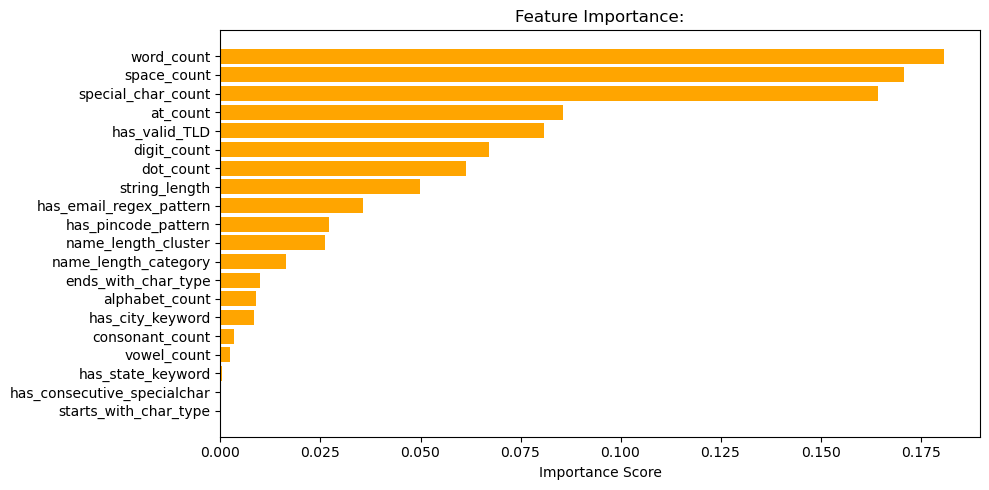


📊 Confusion Matrix:
[[10564   115   104]
 [  138 10529   119]
 [  104   111 10574]]

🧾 Classification Report:
              precision    recall  f1-score   support

        Name       0.98      0.98      0.98     10783
       Email       0.98      0.98      0.98     10786
     Address       0.98      0.98      0.98     10789

    accuracy                           0.98     32358
   macro avg       0.98      0.98      0.98     32358
weighted avg       0.98      0.98      0.98     32358



In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

file_path = 'C:\\Users\\TARU\\OneDrive\\Desktop\\AMITY\\DATA _LG\\1006\\Noisy.xlsx'
df = pd.read_excel(file_path, sheet_name='Features')

y = df['label'].astype(int)
X = df.drop(columns=['data', 'label'])

categorical_cols = X.columns[-3:].tolist()
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=2,
    max_features='log2',
    bootstrap=True,         
    oob_score=True,         
    random_state=42,
)

rf_model.fit(X_train, y_train)

print(f"\n📈 OOB Score: {rf_model.oob_score_:.4f}")
print(f"❌ OOB Error: {1 - rf_model.oob_score_:.4f}")

importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\n🔍 Feature Importances:")
for name, score in feature_importance:
    print(f"{name:<30} {score:.4f}")

top = feature_importance[:]  
labels, scores = zip(*top)

plt.figure(figsize=(10, 5))
plt.barh(labels[::-1], scores[::-1], color='orange')
plt.xlabel("Importance Score")
plt.title("Feature Importance:")
plt.tight_layout()
plt.show()

y_pred = rf_model.predict(X_test)

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Name', 'Email', 'Address']))

# HYPERPARAMETER TUNING

In [5]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],              
    'max_depth': [10, 30],                        
    'min_samples_split': [2, 5],                  
    'min_samples_leaf': [1, 3, 5],                
    'max_features': ['sqrt', 'log2']              
}

rf_base = RandomForestClassifier(
    bootstrap=True,
    oob_score=True,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n✅ Best Parameters:")
print(grid_search.best_params_)
print(f"📊 Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_
print(f"\n📈 OOB Score of Best Model: {best_rf_model.oob_score_:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

print(f"\n🔝 Top 10 Hyperparameter Combinations:")
for i in range(10):
    row = results_df.iloc[i]
    print(f"{i+1:>2}. Accuracy: {row['mean_test_score']:.4f} | Params: {row['params']}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best Parameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
📊 Best Cross-Validation Accuracy: 0.9796

📈 OOB Score of Best Model: 0.9796

🔝 Top 10 Hyperparameter Combinations:
 1. Accuracy: 0.9796 | Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
 2. Accuracy: 0.9796 | Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
 3. Accuracy: 0.9796 | Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
 4. Accuracy: 0.9796 | Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
 5. Accuracy: 0.9796 | Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estima

# FEATURE SELECTION


✅ Best N = 17 features | 📈 Best OOB Score = 0.9796
🧠 Selected Features: ['word_count', 'space_count', 'special_char_count', 'at_count', 'has_valid_TLD', 'digit_count', 'dot_count', 'string_length', 'has_email_regex_pattern', 'has_pincode_pattern', 'name_length_cluster', 'name_length_category', 'ends_with_char_type', 'alphabet_count', 'has_city_keyword', 'consonant_count', 'vowel_count']

📈 OOB Score (Best-N Features): 0.9796
❌ OOB Error: 0.0204

📊 Confusion Matrix:
[[10566   114   103]
 [  139 10530   117]
 [  103   110 10576]]

🧾 Classification Report:
              precision    recall  f1-score   support

        Name       0.98      0.98      0.98     10783
       Email       0.98      0.98      0.98     10786
     Address       0.98      0.98      0.98     10789

    accuracy                           0.98     32358
   macro avg       0.98      0.98      0.98     32358
weighted avg       0.98      0.98      0.98     32358



C:\Users\TARU\AppData\Local\Temp\ipykernel_32276\557088501.py:76: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\TARU\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


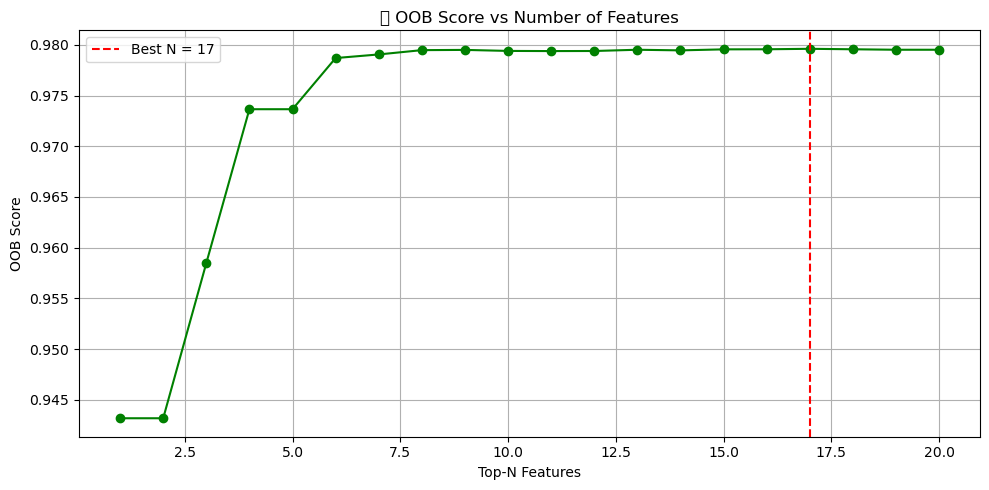

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 🎯 Use importances from rf_model (trained in initial model block)
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
all_features_ranked = [name for name, _ in feature_importance]

# 🔁 Loop through Top-N features and compute OOB score
max_n = len(all_features_ranked)
oob_scores = []

for n in range(1, max_n + 1):
    top_n_features = all_features_ranked[:n]
    X_train_n = X_train[top_n_features]

    rf_temp = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        random_state=42     
    )
    rf_temp.fit(X_train_n, y_train)
    oob_scores.append(rf_temp.oob_score_)

# 🔍 Find best N
best_n = oob_scores.index(max(oob_scores)) + 1
best_features = all_features_ranked[:best_n]

print(f"\n✅ Best N = {best_n} features | 📈 Best OOB Score = {max(oob_scores):.4f}")
print("🧠 Selected Features:", best_features)

# 🎯 Train final model using best-N features
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

rf_best_n = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        random_state=42
)
rf_best_n.fit(X_train_best, y_train)

# ✅ Evaluate
print(f"\n📈 OOB Score (Best-N Features): {rf_best_n.oob_score_:.4f}")
print(f"❌ OOB Error: {1 - rf_best_n.oob_score_:.4f}")

y_pred_best = rf_best_n.predict(X_test_best)

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Name', 'Email', 'Address']))

# 📊 Plot OOB Score vs Top-N
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_n + 1), oob_scores, marker='o', color='green')
plt.axvline(best_n, color='red', linestyle='--', label=f'Best N = {best_n}')
plt.xlabel("Top-N Features")
plt.ylabel("OOB Score")
plt.title("📉 OOB Score vs Number of Features")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# MODEL FITTING ON VALIDATION SET

In [9]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

val_file_path = 'C:\\Users\\TARU\\OneDrive\\Desktop\\AMITY\\DATA _LG\\1006\\Validation.xlsx'
df_val = pd.read_excel(val_file_path, sheet_name='Features_test')

y_val = df_val['label'].astype(int)
X_val = df_val.drop(columns=['data', 'label'])

for col in categorical_cols:
    le = encoders[col]
    X_val[col] = le.transform(X_val[col])

X_val_n = X_val[best_features]
y_val_pred = rf_best_n.predict(X_val_n)

val_results_df = pd.DataFrame({
    'data': df_val['data'],
    'true_label': y_val,
    'predicted_label': y_val_pred
})

with pd.ExcelWriter(val_file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    val_results_df.to_excel(writer, sheet_name='Validation_Predictions', index=False)

print(f"\n✅ Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}\n")
print(classification_report(y_val, y_val_pred, digits=4, target_names=['Name', 'Email', 'Address']))

val_cm = confusion_matrix(y_val, y_val_pred)
print("🧩 Validation Confusion Matrix:")
print(val_cm)

print("\n📁 Validation results saved to 'Validation_Predictions' sheet.")


✅ Validation Accuracy: 0.9067

              precision    recall  f1-score   support

        Name     0.8462    0.8800    0.8627        25
       Email     0.9259    1.0000    0.9615        25
     Address     0.9545    0.8400    0.8936        25

    accuracy                         0.9067        75
   macro avg     0.9089    0.9067    0.9060        75
weighted avg     0.9089    0.9067    0.9060        75

🧩 Validation Confusion Matrix:
[[22  2  1]
 [ 0 25  0]
 [ 4  0 21]]

📁 Validation results saved to 'Validation_Predictions' sheet.


# ROC CURVE

C:\Users\TARU\AppData\Local\Temp\ipykernel_32276\2307004055.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\TARU\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


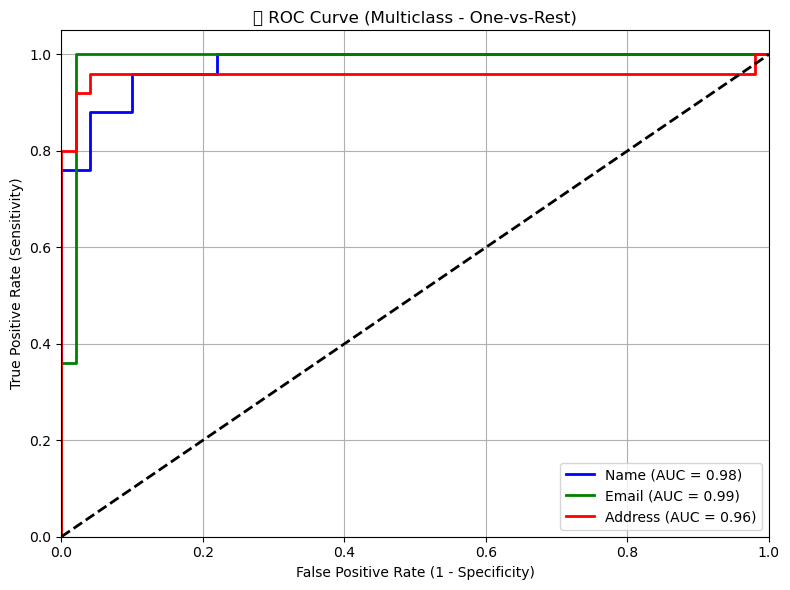

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from itertools import cycle

y_val_bin = label_binarize(y_val, classes=[0, 1, 2])  
n_classes = y_val_bin.shape[1]

y_score = rf_model.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'green', 'red'])
plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    class_label = ['Name', 'Email', 'Address'][i]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('📈 ROC Curve (Multiclass - One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()